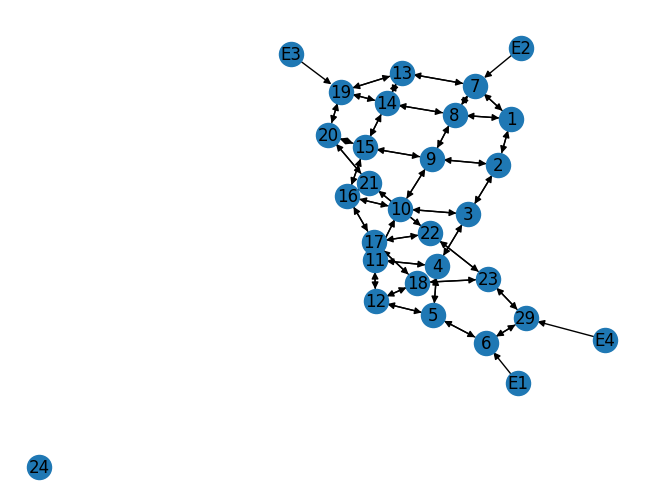

In [1]:
import networkx as nx

G = nx.DiGraph()

intersection_nodes = {
    #ENTRY NODES
    'E1': (600, 80), 
    'E2': (50, 50), 
    'E3': (100, 350),
    'E4': (650, 500),
    #PROPER NODES
    # Nodes below are from the first BGC parallel
    1: (100, 100),
    2: (200, 100),
    3: (300, 100),
    4: (400, 100),
    5: (500, 100),
    6: (600, 125),
    7: (50, 200),
    8: (100, 200),
    9: (200, 150),
    10: (300, 150),
    11: (400, 150),
    12: (500, 150),
    13: (50, 300),
    14: (100, 300),
    15: (200, 350),
    16: (300, 350),
    17: (400, 350),
    18: (500, 350),
    19: (100, 300),
    20: (200, 300),
    21: (300, 300),
    22: (400, 300),
    23: (500, 300),
    24: (600, 450)
}

#use a real layout like EDSA or Ayala or BGC

#('E2', 1)
edge_list = [
    ('E1', 6),('E2', 7),('E3', 19),('E4', 29),
    (1, 2),(1, 8),(1, 7),
    (2, 1),(2, 3),(2, 9),
    (3, 2),(3, 4),(3, 10),
    (4, 3),(4, 5),(4, 11),
    (5, 4),(5, 6),(5, 12),
    (6, 5),(6, 29),
    (7, 1),(7, 8),(7, 13),
    (8, 1),(8, 7),(8, 9),(8, 14),
    (9, 2),(9, 8),(9, 10),(9, 15),
    (10, 3),(10, 9),(10, 11),(10, 16),
    (11, 4),(11, 10),(11, 12),(11, 17),
    (12, 5),(12, 11),(12, 18),
    (13, 7),(13, 14),(13, 19),
    (14, 8),(14, 13),(14, 15),(14, 19),
    (15, 9),(15, 14),(15, 16),(15, 20),
    (16, 10),(16, 15),(16, 17),(16, 21),
    (17, 11),(17, 16),(17, 18),(17, 22),
    (18, 12),(18, 17),(18, 23),
    (19, 13),(19, 14),(19, 20),
    (20, 15),(20, 19),(20, 21),
    (21, 16),(21, 20),(21, 22),
    (22, 17),(22, 21),(22, 23),
    (23, 18),(23, 22),(23, 29),
    (29, 6),(29, 23)
]


for index, pos in intersection_nodes.items():
    G.add_node(index, pos=pos)

# for edge in edge_list:
#     G.add_edge(edge[0], edge[1])

G.add_edges_from(edge_list)

nx.draw(G, with_labels=True)